# Open-loop optimal control of a simple pendulum using multiple-shooting

In this notebook, we will perform open-loop optimal control of a simple pendulum using the multiple-shooting method in CasADi. The multiple-shooting method divides the time horizon into smaller intervals, and solves for the control inputs and states in each interval simultaneously.

First, we will define the pendulum model and the necessary functions for integration and simulation. We will then set up the optimal control problem using CasADi's `Opti` object, define the objective and constraints, choose a solver, and solve the problem. Finally, we will plot the results.

## Pendulum Model

The dynamics of the simple pendulum can be described using the following differential equations:

$$
\begin{align*}
\dot{\theta} &= \theta_{dot} \\
\dot{\theta_{dot}} &= \frac{m \cdot g \cdot l \cdot \sin(\theta) + m \cdot l \cdot \cos(\theta) \cdot u}{I + m \cdot l^2}
\end{align*}
$$

Where:
- $ \theta $ is the angle of the pendulum.
- $ \theta_{dot} $ is the angular velocity.
- $ u $ is the control input (torque).
- $ m $ is the mass.
- $ l $ is the length of the pendulum.
- $ I $ is the moment of inertia.
- $ g $ is the acceleration due to gravity.

Let's define the pendulum model in CasADi.

In [11]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Pendulum parameters
m = 0.2
b = 0.1
l = 0.3
I = 0.006
g = 9.81

a = m * g * l / (I + m * l**2)
b = m * l / (I + m * l**2)

# Define the ODE right-hand side function for the pendulum model
th = ca.MX.sym("th")
thDot = ca.MX.sym("thDot")
u = ca.MX.sym("u")  # Control input

rhs = ca.vertcat(
    thDot,            # dth/dt
    a * ca.sin(th) + b * ca.cos(th) * u  # dth_dot/dt
)

# Pack the ODE system into a dictionary
pendulumModel = {'x': ca.vertcat(th, thDot), 'u': u, 'ode': rhs}

## Multiple Shooting Approach

In direct optimal control, we optimize directly over the states and controls of the system. Multiple shooting is a specific disrect optimal control technique that parameterizes the control input and the states, and solves the optimal control problem by optimizing the free parameters of the input and state trajectories. In this case, we will assume that the control signal is held constant between sample instances, and only consider the state vector at the sample points. We thus divide the time horizon into smaller intervals and optimize the states and controls at these collocation points (the sampling times). 

### Simulation Parameters

Let's define the simulation parameters including the total time horizon, number of control intervals, length of a control interval, and control limits.


In [12]:
# Multiple Shooting Approach
T = 3  # Total time horizon
N = 10*T  # number of control intervals
dt = T / N  # Length of a control interval
ulim = 10  # Control limits

### CasADi's `Opti` Object

CasADi provides the `Opti` object to define and solve optimization problems. The `Opti` object allows a convenient mechanism to define nonlinear programming problems by specifying variables, objectives, constraints, and solvers. We use `Opti` to set up our optimal control problem.

### Define Decision Variables

We define the state and control trajectories as decision variables in the optimization problem.


In [13]:
# Define decision variables
opti = ca.Opti()           # Instantiate on Opti object
X = opti.variable(2, N+1)  # State trajectory
U = opti.variable(1, N)    # Control trajectory

### Objective Function

The objective function defines the cost we want to minimize. In this case, we will use a quadratic cost function for the state and control trajectories. The cost function is given by:

$$
J = \sum_{k=0}^{N-1} \left( x_k^T Q x_k + u_k^T R u_k \right) + x_N^T Q_N x_N
$$

Where:
- $ x_k $ is the state at time step $ k $.
- $ u_k $ is the control input at time step $ k $.
- $ Q $ and $ R $ are the state and control weight matrices, respectively.
- $ Q_N $ is the terminal state weight matrix.

In [14]:
# Objective
Q = ca.diag([1, 1])
R = ca.diag([1])
Q_N = ca.diag([1, 1])

cost = 0
for k in range(N):
    x_k = X[:, k]
    u_k = U[:, k]
    cost += ca.mtimes([x_k.T, Q, x_k]) + ca.mtimes([u_k.T, R, u_k])

# Terminal cost
x_N = X[:, -1]
cost += ca.mtimes([x_N.T, Q_N, x_N])

opti.minimize(cost)

### Discretizing the dynamics

We will use the Ruge-Kutta method to transform the continuous-time model
\begin{align*}
    \dot{x}(t) &= f_c(x(t), u(t))
\end{align*}
into a discrete-time model
\begin{align*}
    x_{k+1}&= f(x_k, u_k)
\end{align*}
under the assumption that $u(t)$ is constant across sampling periods of length dt. Later, we will use a convenience class for this integration. But now, we define it ourselves.

In [15]:
# Function to perform one step of RK4 integration
def rk4_step(ode, x, u, dt):
    k1 = ode(x, u)
    k2 = ode(x + dt/2 * k1, u)
    k3 = ode(x + dt/2 * k2, u)
    k4 = ode(x + dt * k3, u)
    return x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)


f_c = ca.Function('f_c', [pendulumModel['x'], pendulumModel['u']], [rhs])

# Define the RK4 integrator
dt = 0.1  # time step
f = ca.Function('f', [pendulumModel['x'], pendulumModel['u']], [rk4_step(f_c, pendulumModel['x'], pendulumModel['u'], dt)])

### Constraints

We will define the following constraints:
- Dynamic constraints: Ensure the state trajectory follows the system dynamics.
- Control constraints: Ensure the control inputs are within the specified limits.
- Boundary conditions: Specify the initial and final states of the pendulum.


In [16]:
# Dynamic constraints
for k in range(N):
    x_k = X[:, k]
    u_k = U[:, k]
    x_next = f(x_k, u_k)
    opti.subject_to(X[:, k+1] == x_next)

# Control constraints
opti.subject_to(opti.bounded(-ulim, U, ulim))

# Boundary conditions
opti.subject_to(X[:, 0] == [np.pi, 0])  # Initial state
opti.subject_to(X[:, -1] == [0, 0])    # Final state

### Initial Guesses

Providing good initial guesses can help the solver converge more quickly. For the state trajectory, we will use linear interpolation from the initial state to the final state over the horizon, while for the control input we will just set it to zero. Note that this initialization is not consistent, and better initializations can be provided, as described in the lecture notes.

In [17]:
# Initial guesses
theta_init = np.linspace(np.pi, 0, N+1)
theta_dot_init = np.linspace(0, 0, N+1)
opti.set_initial(X[0, :], theta_init)
opti.set_initial(X[1, :], theta_dot_init)
opti.set_initial(U, 0)

### Solver Options

We will use the IPOPT solver and set its options to enable printing and increase the number of iterations.


In [18]:
# Solver options to enable printing and increase iterations
p_opts = {'print_time': True}
s_opts = {
    'print_level': 3, 
    'max_iter': 5000
}
opti.solver('ipopt', p_opts, s_opts)

### Solve the Problem

We can now solve the optimization problem and extract the solution.

In [19]:
# Solve the problem
sol = opti.solve()

# Extract the solution
x_sol = sol.value(X)
u_sol = sol.value(U)

Total number of variables............................:       92
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       30
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       30
        inequality constraints with only upper bounds:        0


Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   7.1912709294040906e+02    7.1912709294040906e+02
Dual infeasibility......:   2.2453150450019166e-11    2.2453150450019166e-11
Constraint violation....:   2.7267077484793845e-13    2.7267077484793845e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

## Plot the Results

Finally, we will plot the state and control trajectories.

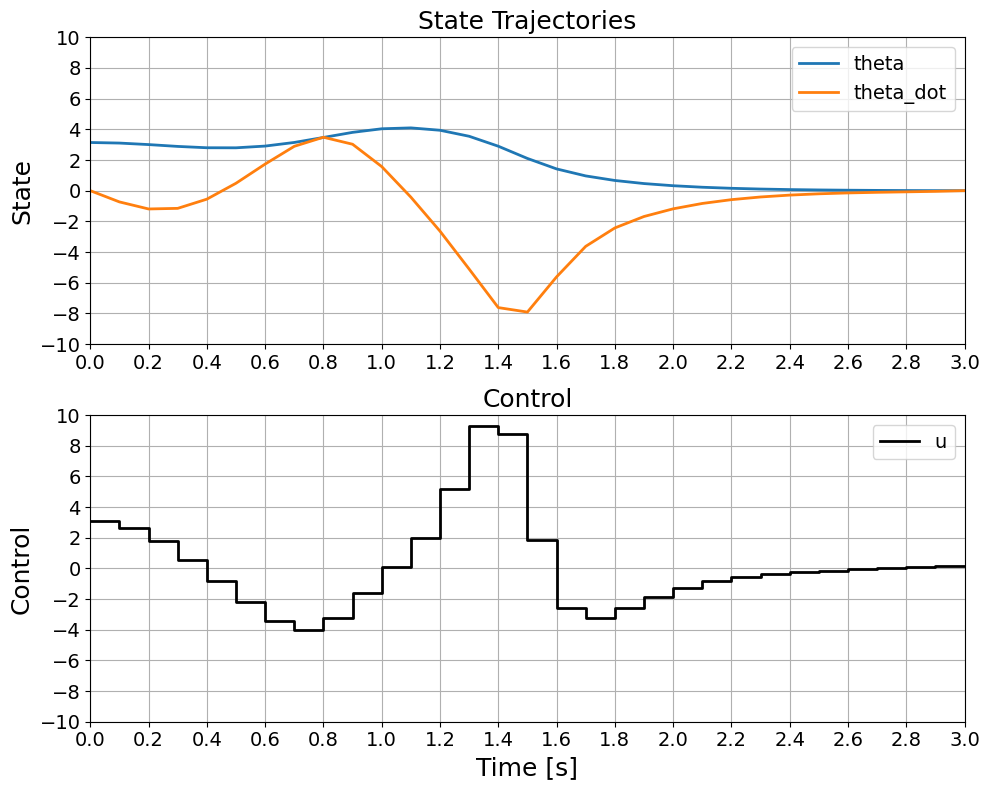

In [20]:
# Time grid for plotting
t_grid = np.linspace(0, T, N + 1)

# Extend the control signal for plotting
u_sol_extended = np.append(u_sol, u_sol[-1])

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the state trajectories on the first subplot
ax1.plot(t_grid, x_sol[0, :], label='theta', linewidth=2)
ax1.plot(t_grid, x_sol[1, :], label='theta_dot', linewidth=2)
#ax1.set_xlabel('Time [s]')
ax1.set_ylabel('State', fontsize=18)
ax1.set_xlim([0, T])
ax1.set_ylim([-10, 10])
ax1.legend(fontsize=14)
ax1.set_title('State Trajectories', fontsize=18)
ax1.grid()

# Set grid steps
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Plot the control trajectory on the second subplot
ax2.step(t_grid, u_sol_extended, 'k', label='u', where='post', linewidth=2)
ax2.set_xlabel('Time [s]', fontsize=18)
ax2.set_ylabel('Control', fontsize=18)
ax2.set_xlim([0, T])
ax2.set_ylim([-10, 10])
ax2.legend(fontsize=14)
ax2.set_title('Control', fontsize=18)
ax2.grid()

# Set grid steps
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(2))

# Set tick font size
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()